In [1]:
import sys
sys.path.append('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github')

In [ ]:

# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
import math
import numpy as np
import pandas as pd
import random
import scipy.sparse as sp
from utils import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df, threshold_interactions_df_plus, train_test_split_csr

!pip install surprise
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter
from collections import defaultdict

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from pct.tree.heuristic.Heuristic import Heuristic5
from pct.tree.heuristic.NumericHeuristic import NumericHeuristic5
from pct.tree.splitter.splitter import Splitter
from pct.tree.tree import Tree


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:

my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)

def load_user_item_matrix(filepath):
    data = []

    with open(filepath, 'r') as f:
        while True:
            user_line = f.readline()
            if not user_line:
                break

            user_line = user_line.strip()
            if '|' not in user_line:
                continue

            user_id, num_ratings = user_line.split('|')
            user_id = int(user_id)
            num_ratings = int(num_ratings)

            for _ in range(num_ratings):
                item_line = f.readline().strip()
                parts = item_line.split('\t')
                if len(parts) < 2:
                    continue
                item_id, score = parts[0], parts[1]
                data.append([user_id, int(item_id), int(score)])

    df = pd.DataFrame(data, columns=['user_id', 'item_id', 'rating'])
    return df


In [4]:
def safe_int(x):
    return int(x) if x != 'None' else 0


def load_track_data(filepath):
    track_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('|')
            track_id = safe_int(parts[0])
            album_id = safe_int(parts[1])
            artist_id = safe_int(parts[2])
            genre_ids = [safe_int(g) for g in parts[3:]] if len(parts) > 3 else []
            track_data.append([track_id, album_id, artist_id, genre_ids])
    return pd.DataFrame(track_data, columns=['track_id', 'album_id', 'artist_id', 'genre_ids'])

def load_album_data(filepath):
    album_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('|')
            album_id = safe_int(parts[0])
            artist_id = safe_int(parts[1])
            genre_ids = [safe_int(g) for g in parts[2:]] if len(parts) > 2 else []
            album_data.append([album_id, artist_id, genre_ids])
    return pd.DataFrame(album_data, columns=['album_id', 'artist_id', 'genre_ids'])


# read artistData2
def load_artist_data(filepath):
    with open(filepath, 'r') as f:
        artist_ids = [int(line.strip()) for line in f]
    return pd.DataFrame(artist_ids, columns=['artist_id'])

# read genreData2
def load_genre_data(filepath):
    with open(filepath, 'r') as f:
        genre_ids = [int(line.strip()) for line in f]
    return pd.DataFrame(genre_ids, columns=['genre_id'])

In [5]:
track_df = load_track_data('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/yahoo_data/ydata-ymusic-kddcup-2011-track2/trackData2.txt')
track_df

,track_id,album_id,artist_id,genre_ids
0,1,106710,281667,"[214765, 162234, 155788]"
1,2,280977,233685,"[131552, 173467, 48505]"
2,3,38422,219136,"[61215, 201738, 88853]"
3,4,119529,166863,"[17453, 35389]"
4,5,16742,294690,"[61215, 34486, 274088]"
...,...,...,...,...
224036,296100,166516,33011,"[274088, 199606, 88853]"
224037,296101,0,0,[]
224038,296102,153644,289056,"[158282, 139095, 242383]"
224039,296105,68336,6613,[82064]


In [6]:
album_df = load_album_data('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/yahoo_data/ydata-ymusic-kddcup-2011-track2/albumData2.txt')
album_df

,album_id,artist_id,genre_ids
0,0,0,[214765]
1,6,228091,"[158282, 81520, 242383]"
2,19,85028,[103715]
3,30,16832,[31567]
4,33,26330,"[149962, 209270]"
...,...,...,...
52824,296104,125866,[158282]
52825,296106,221637,"[116130, 9432]"
52826,296107,0,[61215]
52827,296108,93277,[61215]


In [7]:
artist_df = load_artist_data('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/yahoo_data/ydata-ymusic-kddcup-2011-track2/artistData2.txt')
artist_df

,artist_id
0,16
1,23
2,35
3,40
4,49
...,...
18669,295987
18670,296007
18671,296012
18672,296013


In [8]:
genre_df = load_genre_data('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/yahoo_data/ydata-ymusic-kddcup-2011-track2/genreData2.txt')
genre_df

,genre_id
0,208
1,315
2,642
3,1075
4,1271
...,...
562,292093
563,293670
564,293688
565,294138


In [9]:
train_path = '/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/yahoo_data/ydata-ymusic-kddcup-2011-track2/trainIdx2.txt'
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
train_df = load_user_item_matrix(train_path)


In [10]:
train_df

,user_id,item_id,rating
0,0,28341,90
1,0,51210,90
2,0,79500,90
3,0,82317,90
4,0,98399,90
...,...,...,...
61944401,249011,270557,90
61944402,249011,273574,90
61944403,249011,286938,90
61944404,249011,287681,80


In [11]:
duplicate_counts = train_df.groupby(['user_id', 'item_id']).size()
duplicates = duplicate_counts[duplicate_counts > 1]

print(f"🔁 Number of duplicated (user_id, item_id) pairs: {len(duplicates)}")
print(duplicates.head())


🔁 Number of duplicated (user_id, item_id) pairs: 0
Series([], dtype: int64)


In [12]:
print(train_df['item_id'].max())      # highest item_id
print(track_df['track_id'].max())     # highest track_id
print(train_df['item_id'].isin(track_df['track_id']).mean())  # proportion to match

print(train_df['item_id'].isin(album_df['album_id']).mean())

print(train_df['item_id'].isin(artist_df['artist_id']).mean())

print(train_df['item_id'].isin(genre_df['genre_id']).mean())



296110
296110
0.4385845107627636
0.1925648621120041
0.3114063600835885
0.05744426704164376


In [13]:
def build_item_metadata(track_df, album_df, artist_df, genre_df):
    rows = []

    # 1. Tracks
    for _, row in track_df.iterrows():
        rows.append({
            'item_id': row['track_id'],
            'item_type': 'track',
            'artist_id': row['artist_id'],
            'genre_ids': row['genre_ids']
        })

    # 2. Albums
    for _, row in album_df.iterrows():
        rows.append({
            'item_id': row['album_id'],
            'item_type': 'album',
            'artist_id': row['artist_id'],
            'genre_ids': row['genre_ids']
        })

    # 3. Artists
    for artist_id in artist_df['artist_id']:
        rows.append({
            'item_id': artist_id,
            'item_type': 'artist',
            'artist_id': artist_id,
            'genre_ids': 0
        })

    # 4. Genres
    for genre_id in genre_df['genre_id']:
        rows.append({
            'item_id': genre_id,
            'item_type': 'genre',
            'artist_id': 0,
            'genre_ids': [genre_id]
        })

    return pd.DataFrame(rows)

In [14]:
item_meta_df = build_item_metadata(track_df, album_df, artist_df, genre_df)


train_with_meta = train_df.merge(item_meta_df, on='item_id', how='inner')

# When loading the data, sort by a stable column (e.g., user_id)
train_with_meta = train_with_meta.sort_values('user_id').reset_index(drop=True)

train_with_meta

,user_id,item_id,rating,item_type,artist_id,genre_ids
0,0,28341,90,artist,28341,0
1,0,232604,30,artist,232604,0
2,0,237425,50,artist,237425,0
3,0,245257,50,artist,245257,0
4,0,23301,50,artist,23301,0
...,...,...,...,...,...,...
61944401,249011,141075,90,artist,141075,0
61944402,249011,150385,80,genre,0,[150385]
61944403,249011,152077,90,artist,152077,0
61944404,249011,158282,80,genre,0,[158282]


In [15]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Step 1: Prepare data
df = train_with_meta.copy()
# drop "album', 'track" items before all processing
df = train_with_meta[~train_with_meta['item_type'].isin(['album', 'track'])].copy()

# Encode user_id and item_id to indices
user_ids = np.sort(df['user_id'].unique())
item_ids = np.sort(df['item_id'].unique())

user_id_map = {uid: i for i, uid in enumerate(user_ids)}
item_id_map = {iid: i for i, iid in enumerate(item_ids)}

# Step 2: Create user-item sparse rating matrix manually
row_indices = df['user_id'].map(user_id_map)
col_indices = df['item_id'].map(item_id_map)
ratings = df['rating'].astype(float)

n_users = len(user_ids)
n_items = len(item_ids)

user_item_sparse = csr_matrix((ratings, (row_indices, col_indices)), shape=(n_users, n_items))

# Step 3: Select core users (or choose active users manually)
np.random.seed(7)
core_indices = np.random.choice(n_users, size=5, replace=False)

# Step 4: Compute cosine similarity between core users and all users
sim_matrix = cosine_similarity(user_item_sparse[core_indices], user_item_sparse)
max_sim = sim_matrix.max(axis=0)

# Step 5: Pick top-K most similar users
top_k = 50000
top_user_indices = np.argsort(max_sim)[-top_k:]
sampled_user_ids = user_ids[top_user_indices]

# Step 6: Filter original data
user_filtered_df = df[df['user_id'].isin(sampled_user_ids)]

# Step 7: Summary
print(f"🎯 Sample shape: {user_filtered_df.shape}")
print(f"👤 Users: {user_filtered_df['user_id'].nunique()}, 🎵 Items: {user_filtered_df['item_id'].nunique()}")

🎯 Sample shape: (3305637, 6)
👤 Users: 50000, 🎵 Items: 15778


In [16]:
filtered_df = threshold_interactions_df_plus(user_filtered_df, min_items_per_user=150, min_artists_per_user=20, min_genres_per_user=10,min_users_per_item=150)

Initial: users = 50000, items = 15778, sparsity = 0.4190%
After item filtering: users = 2315, items = 992, sparsity = 22.0430%
Final: users = 1827, items = 992, sparsity = 22.5399%


In [28]:
filtered_df

,user_id,item_id,rating,item_type,artist_id,genre_ids
38739,130,59092,50,artist,59092,0
38741,130,162885,50,artist,162885,0
38742,130,94918,50,artist,94918,0
38743,130,128573,50,artist,128573,0
38744,130,179354,30,artist,179354,0
...,...,...,...,...,...,...
61902008,248860,230208,0,artist,230208,0
61902035,248860,166257,0,artist,166257,0
61902046,248860,222273,0,artist,222273,0
61902062,248860,161937,0,artist,161937,0


In [29]:
all_user_ids = sorted(filtered_df['user_id'].unique())
warm_users = all_user_ids[:160]
cold_users = all_user_ids[160:]


df_warm = filtered_df[filtered_df['user_id'].isin(warm_users)].copy()
df_cold = filtered_df[filtered_df['user_id'].isin(cold_users)].copy()

matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
    df_warm, "user_id", "item_id", "rating")


matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix( 
    df_cold, "user_id", "item_id", "rating")



In [30]:
def split_and_combine(strategy="artist-only"):
    """Handles both approaches with proper matrix alignment"""
    # Get full cold matrix and mappings
    matrix_cold, rid_to_idx_cold, _, cid_to_idx, _ = df_to_matrix(
        df_cold, "user_id", "item_id", "rating"
    )
    matrix_cold = matrix_cold.tocsr()

    # Create boolean masks
    artist_mask = np.isin(
        np.arange(matrix_cold.shape[1]), 
        [cid_to_idx[iid] for iid in df_cold[df_cold['item_type'] == 'artist']['item_id']]
    )
    genre_mask = ~artist_mask

    # Create aligned matrices
    matrix_cold_artist = matrix_cold.multiply(artist_mask)
    matrix_cold_genre = matrix_cold.multiply(genre_mask)
    matrix_cold_artist = matrix_cold.multiply(artist_mask).tocsr()
    matrix_cold_genre = matrix_cold.multiply(genre_mask).tocsr()

    al_artist, test_cold, _ = train_test_split(
        matrix_cold_artist, 
        split_count=30,
        fraction=None
    )
    
    if strategy == "artist-only":
        X_cold, K_cold, _ = train_test_split_csr(al_artist, 1)
        K_cold = K_cold + matrix_cold_genre  
        return K_cold, X_cold, test_cold
    
    elif strategy == "hybrid":
        combined = al_artist + matrix_cold_genre
        X_cold, K_cold, _ = train_test_split_csr(combined, 1)
        return K_cold, X_cold, test_cold


In [31]:
train_cold_K_artist, X_cold_artist, test_cold_artist  = split_and_combine("artist-only")


In [32]:
train_cold_K_hybrid, X_cold_hybrid, test_cold_hybrid = split_and_combine("hybrid")


In [22]:
# shape of test_cold

print(f"Cold users in X: {len(np.unique(X_cold_artist.nonzero()[0]))}")
print(f"Cold items in X: {len(np.unique(X_cold_artist.nonzero()[1]))}")
print(f"test users in test: {len(np.unique(test_cold_artist.nonzero()[0]))}")
print(f"test items in test: {len(np.unique(test_cold_artist.nonzero()[1]))}")
print(f"train users in train: {len(np.unique(train_cold_K_artist.nonzero()[0]))}")
print(f"train items in train: {len(np.unique(train_cold_K_artist.nonzero()[1]))}")

Cold users in X: 1666
Cold items in X: 898
test users in test: 1664
test items in test: 898
train users in train: 1658
train items in train: 587


In [23]:
# shape of test_cold
print(f"Shape of test_cold: {test_cold_artist.shape}")
print(f"Shape of train_cold: {train_cold_K_artist.shape}")
print(f"Shape of X_cold: {X_cold_artist.shape}")

Shape of test_cold: (1667, 992)
Shape of train_cold: (1667, 992)
Shape of X_cold: (1667, 992)


In [ ]:
from collections import defaultdict


def elicitation_by_tree_path_retrain_skiped_warm(tree_model_class, train, test, X, matrix_warm, idx_to_rid_cold, idx_to_rid_warm, idx_to_cid, iteration=5):
    """
    Method 3 (revised): Retrain tree at each round. For each user, traverse from root down the tree.
    At each level, if the item was already asked (stored in asked_items), go deeper.
    Ask the first item the user hasn't been asked before.

    Parameters:
    - tree_model_class: class of the decision tree model (not instance)
    - train, test, X: lil_matrix (known ratings, test set, and full matrix)
    - idx_to_rid, idx_to_cid: index-to-ID mapping
    - iteration: number of elicitation rounds

    Returns:
    - rmse_list, mae_list
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}
    asked_items = {u: set() for u in range(num_users)}  

    # Step 0: Baseline evaluation
    print("🔍 Evaluating baseline RMSE/MAE...")
    train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
    reader = Reader(rating_scale=(1, 100))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (skip asked items, walk from root)")
        # Retrain tree using current train_copy
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        coldK_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, coldK_df], ignore_index=False)

        pct = Tree(max_depth=i + 1, min_instances=5)
        pct.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        for u in range(num_users):
            node = pct.root

            # Traverse down the tree until we find an unasked item
            while node and not node.is_leaf and node.attribute_name:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break

                item_idx = cid_to_idx[item]

                if item_idx in asked_items[u]:
                    # Already asked, go deeper based on user's rating
                    rating = train_copy[u, item_idx]
                    if rating > 50:
                        node = node.children[0]
                    elif rating > 0:
                        node = node.children[1]
                    else:
                        node = node.children[2]
                    continue

                # First unasked item: try to add it to training
                asked_items[u].add(item_idx)  
                rating = X_copy[u, item_idx]
                if rating > 0:
                    train_copy[u, item_idx] = rating
                    X_copy[u, item_idx] = 0
                break  # only ask one item per user per iteration

        # Step 3: Evaluate with SVD
        print("📊 Evaluating after this iteration...")
        train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list

# X with artist only

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_artist_only = elicitation_by_tree_path_retrain_skiped_warm(
    tree_model_class=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=15
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 24.2226
MAE:  20.9104
✅ Baseline evaluation complete.

🔁 Iteration 1/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 24.2682
MAE:  20.9552
✅ Iteration 1 complete.

🔁 Iteration 2/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 24.2579
MAE:  20.9675
✅ Iteration 2 complete.

🔁 Iteration 3/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 24.2563
MAE:  20.9551
✅ Iteration 3 complete.

🔁 Iteration 4/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 24.2609
MAE:  20.9730
✅ Iteration 4 complete.

🔁 Iteration 5/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 24.2972
MAE:  21.0143
✅ Iteration 5 complete.

🔁 Iteration 6/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 24.2679
MAE:  20.9681
✅ Iteration 6 complete.

🔁 Iteration 7/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 24.2185
MAE:  20.9419
✅ Iteration 7 complete.


([24.222567205959418,
  24.26824175174528,
  24.257901876485924,
  24.256343687085284,
  24.26091077218245,
  24.297233373740568,
  24.267864445770808,
  24.218523032010182],
 [20.910380244785525,
  20.955180413600875,
  20.967490710065736,
  20.95512372922529,
  20.972954368127123,
  21.014277531306934,
  20.968050563759256,
  20.94186713057916])

# X with artist + genre

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_hybrid = elicitation_by_tree_path_retrain_skiped_warm(
    tree_model_class=Tree,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=15
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 26.0925
MAE:  23.3791
✅ Baseline evaluation complete.

🔁 Iteration 1/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 25.2747
MAE:  22.7755
✅ Iteration 1 complete.

🔁 Iteration 2/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 25.2645
MAE:  22.7575
✅ Iteration 2 complete.

🔁 Iteration 3/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 25.2396
MAE:  22.7422
✅ Iteration 3 complete.

🔁 Iteration 4/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 25.0028
MAE:  22.5724
✅ Iteration 4 complete.

🔁 Iteration 5/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 23.9999
MAE:  21.6623
✅ Iteration 5 complete.

🔁 Iteration 6/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 23.8367
MAE:  21.5257
✅ Iteration 6 complete.

🔁 Iteration 7/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 23.3090
MAE:  20.9581
✅ Iteration 7 complete.


# Alternative Method

In [42]:
def i_variance(matirx):
    c = matrix.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()

def i_random(matirx):
    c = matrix.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()

def i_entropy(matirx):
    entropy = []
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        len_rating = len(ratings)
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/len_rating)*math.log(count_r[c]/len_rating)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_entropy_0(matirx):
    entropy = []
    c_all = matirx.shape[0]
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        count_r[0] = c_all - matirx.getcol(item).count_nonzero()
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/c_all)*math.log(count_r[c]/c_all)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_pop(matrix):
    popularity = []
    for item in range(0, matrix.shape[1]):
        popularity.append(matrix.getcol(item).count_nonzero())
        
    return (np.asarray(popularity))

def log_pop_entropy(matrix):
    entropy = i_entropy(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def log_pop_entropy0(matrix):
    entropy = i_entropy_0(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def sqrt_pop_variance(matrix):
    variance = i_variance(matrix)
    popularity = i_pop(matrix)
    scores = np.sqrt(popularity) *  variance 
    return (np.asarray(scores))

def helf(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def helf0(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy_0(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def i_co_rate(matrix):
    matrix_c = matrix.copy()
    matrix_c[matrix_c != 0] = 1
    c= matrix_c.T.dot(matrix_c)
    c.setdiag(0, k=0)
    
    return np.asarray(c.sum(axis=0))[0]

In [50]:
import scipy.sparse as sp


def elicitation_np_warm(matrix_warm, train,test,X,strategy,iteration,k,positive=False):
    rmse,mae = [],[]
    
    # Performance before elicitation
    train_df = matrix_to_df_2(train,idx_to_rid_cold,idx_to_cid)
    reader = Reader(rating_scale=(1, 100))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)
    test_df = matrix_to_df_2(test,idx_to_rid_cold,idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions= algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    
    c_u_dict = {}
    all_items = list(range(0,train.shape[1]))
    X_copy = (X.tolil()).copy()
    warm_copy = matrix_warm.tolil().copy()
    train_copy = (train.tolil()).copy()
    

    #scores = strategy(train_copy)
    
    for count in range(0,iteration-1):
        x_matrix = sp.vstack([warm_copy, train_copy])
        scores = strategy(x_matrix)
        if positive:
            ranking = np.argsort(-scores)
        else:
            ranking = np.argsort(scores)
        for u in range(0, train.shape[0]):
            if count ==0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items,p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()                
          
            ranking_u = ranking[np.in1d(ranking,c_u)]
            topk_u = ranking_u[:k]
            c_u_dict[u] = set_diff(c_u,topk_u)
            px_u = X_copy.getrow(u).nonzero()[1]
            recom = set_intersection(topk_u,px_u)
            for item in recom:                  
                train_copy[u,item] = X[u,item]
                X_copy[u,item] = 0
        train_df = matrix_to_df_2(train_copy,idx_to_rid_cold,idx_to_cid)

        reader = Reader(rating_scale=(1, 100))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)
        test_df = matrix_to_df(test,idx_to_rid_cold,idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions= algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))
        
        print(count+1)
    return rmse,mae

In [56]:
entropy0_hybrid = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    strategy=i_entropy_0,
    iteration=15,
    k=1,
    positive=False
)

RMSE: 26.0928
MAE:  23.3768
RMSE: 26.0283
MAE:  23.3360
1
RMSE: 26.1134
MAE:  23.3939
2
RMSE: 26.0777
MAE:  23.3703
3
RMSE: 25.9515
MAE:  23.2732
4
RMSE: 25.3813
MAE:  22.8830
5
RMSE: 25.3313
MAE:  22.8441
6
RMSE: 25.2728
MAE:  22.8006
7
RMSE: 25.3956
MAE:  22.8937
8
RMSE: 25.3321
MAE:  22.8385
9
RMSE: 25.3793
MAE:  22.8628
10
RMSE: 25.3364
MAE:  22.8293
11
RMSE: 25.0879
MAE:  22.6449
12
RMSE: 25.0546
MAE:  22.6204
13
RMSE: 25.0164
MAE:  22.5872
14


In [52]:
entropy0_artist = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=i_entropy_0,
    iteration=15,
    k=1,
    positive=False
)

RMSE: 24.0103
MAE:  20.6722
RMSE: 23.7513
MAE:  20.5432
1
RMSE: 23.6877
MAE:  20.4909
2
RMSE: 23.6810
MAE:  20.5066
3
RMSE: 23.6683
MAE:  20.4776
4
RMSE: 23.6398
MAE:  20.4794
5
RMSE: 23.6183
MAE:  20.4112
6
RMSE: 23.5757
MAE:  20.4252
7
RMSE: 23.5620
MAE:  20.3978
8
RMSE: 23.5207
MAE:  20.3594
9
RMSE: 23.5069
MAE:  20.3539
10
RMSE: 23.5500
MAE:  20.3701
11
RMSE: 23.5158
MAE:  20.3665
12
RMSE: 23.5187
MAE:  20.3430
13
RMSE: 23.4572
MAE:  20.3066
14


# Max performance

This code snippet creates a combined mapping of user indices to user IDs by merging two separate mappings: idx_to_rid_warm and idx_to_rid_cold. These mappings likely represent two distinct groups of users, such as "warm" users (existing or frequent users) and "cold" users (new or infrequent users). The goal is to ensure that all users are represented in a single unified index space.

The combined_idx_to_rid dictionary is constructed using Python's dictionary unpacking syntax (**). The first part, **idx_to_rid_warm, directly includes all key-value pairs from the idx_to_rid_warm dictionary. This means that the warm user indices are added to the combined mapping without any modification.

The second part, {k + len(idx_to_rid_warm): v for k, v in idx_to_rid_cold.items()}, processes the idx_to_rid_cold dictionary. Here, a dictionary comprehension is used to offset the keys (indices) of the cold users by the length of the idx_to_rid_warm dictionary. This ensures that the cold user indices do not overlap with the warm user indices. Specifically, for each key-value pair (k, v) in idx_to_rid_cold, the key k is incremented by the number of warm users (len(idx_to_rid_warm)), while the value v (the user ID) remains unchanged.

The resulting combined_idx_to_rid dictionary contains all the warm user indices followed by the offset cold user indices, each mapped to their respective user IDs. This approach ensures that the indices for the two groups are unique and avoids any conflicts when combining the mappings.

In [33]:
# Create combined user index mapping
combined_idx_to_rid = {
    **idx_to_rid_warm,  # Original warm user indices
    **{k + len(idx_to_rid_warm): v for k, v in idx_to_rid_cold.items()}  # Offset cold user indices
}

In [47]:
def elicitation_by_tree_path_max_performance(
    
    train,              # lil_matrix: cold users' known ratings (1 item/user, updated over rounds)
    test,               # lil_matrix: cold users' test ratings (30 ratings/user), fixed
    X,                  # lil_matrix: cold users' "hidden" ratings, revealed 1 per round
    matrix_warm,        # lil_matrix: warm users' full ratings
    idx_to_rid_cold,    # cold user index → user_id
    idx_to_rid_warm,    # warm user index → user_id
    idx_to_cid,         # item index → item_id
    # iteration=5
):

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    # train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)

    # KX is the matrix of warm, cold train and cold X
    cold_KX = train.copy() + X.copy()
    warm_coldKX = sp.vstack([matrix_warm.copy(), cold_KX.copy()])
    warm_coldKX_copy = warm_coldKX.tolil().copy()
    warm_coldKX_df = matrix_to_df_2(warm_coldKX_copy, combined_idx_to_rid, idx_to_cid) # Use combined mapping for KX_df

    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline SVD using only cold-start (1 rating per user)
    reader = Reader(rating_scale=(1, 100))
    algo = SVD()
    KXtrainset = Dataset.load_from_df(warm_coldKX_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
    algo.fit(KXtrainset)

    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    

       

    return rmse_list, mae_list


In [48]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

max_performance_artist =elicitation_by_tree_path_max_performance(

    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    # iteration=8
)

RMSE: 38.9403
MAE:  30.7204
✅ Baseline evaluation complete.


In [49]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

max_performance_artist =elicitation_by_tree_path_max_performance(

    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    # iteration=8
)

RMSE: 39.2694
MAE:  31.0513
✅ Baseline evaluation complete.


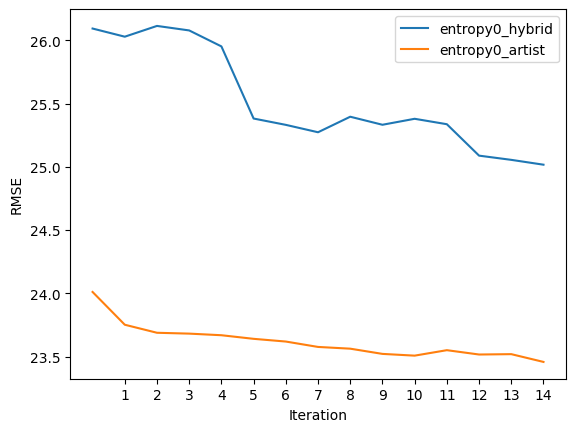

In [57]:
x = np.arange(0,15) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
# ax1.plot(x, pct_hybrid[0], label='pct_hybrid')
ax1.plot(x, entropy0_hybrid[0], label='entropy0_hybrid')
ax1.plot(x, entropy0_artist[0], label='entropy0_artist')
# ax1.plot(x, pct_2[0], label='pct_2')
# ax1.plot(x, pct_3[0], label='pct_3')

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 15)) 
plt.show()